### Objective
The objective of this project is to train a generative language model capable of producing original text in the poetic style of Shakespeare. The models take a prompt as an input and return a sentence in the aforementioned style. To achieve this, we will implement and compare two types of models: a recurrent neural network (LSTM RNN) and a transformer-based (GPT-2) model. 

The RNN serves as a baseline due to its simplicity, while the transformer offers a modern, attention-based approach known for superior performance in capturing long-range dependencies in text. This comparison allows us to evaluate the trade-offs between model complexity, training efficiency, and generation quality in the context of text generation.

The trained LSTM model is saved in the github repo with other documents from the project. If you want to use the model, you dont need to retrain unless you want to try different hyperparamters or design.

The GPT2-transformer model is a pr-trained model from [huggingface Open AI community ](https://huggingface.co/openai-community/gpt2). The model was tuned (transfer learning) by the [Shakespeare plays](https://www.kaggle.com/datasets/kingburrito666/shakespeare-plays) dataset from kaggle, containing over 100,000 lines of dialogue attributed to individual characters across various works. Each line is accompanied by metadata including the play title, act and scene identifiers, and speaker information. 

The tuned GPT-2 model was stored in my [huggingface model repo](https://huggingface.co/Bilal1jk/Shakespeare-Bot). This gives any user access to the tuned model using huggingface API. This eliminated the need for re-trainning which can be costly.

GPUs from Kaggle and google colab were utilized to train both the LSTM RNN and GPT-2 transformer models.

Measuring accuracy in generative models can be tricky. Although discriminators can help tune, improve and compare the models but due to the limited time and GPU resources, that was not utilized. We instead relied on the common qualitative approach of evaluating the generated samples. Since all models are pre-trained, feel free to use your own words and compare the two models in your local.

[Github Repo](https://github.com/Bilal1k/Shakespeare_Bot)

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from collections import Counter
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch
import torch.nn.functional as F
from transformers import GPT2Tokenizer, Trainer, TrainingArguments, TextDataset, DataCollatorForLanguageModeling
from transformers import GPT2LMHeadModel
from transformers import TextDataset, DataCollatorForLanguageModeling
import json
import os
import kagglehub

In [37]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

### Stored Models and Hyperparams

In order to reduce the re-modeling and tuning effort on me and any other user of this project, I've stored the outputs that needed a gpu and a long time in the project repo. If you want to run the project without going through the effort of re-tuning and training, downlaod these files and make sure the following links represent your setup.

In [55]:
# Tuned hyperparams for the LSTM model
best_config_LSTM_path = 'best_config_LSTM.json'

# LSTM training history path
LSTM_history_path = 'LSTM_history.json'

# the LSTM model
LSTMModelPath = 'char_lstm_best.pt'

In [39]:
# Download latest version
path = kagglehub.dataset_download("kingburrito666/shakespeare-plays")

print("Path to dataset files:", path)
df = pd.read_csv(path + "/Shakespeare_data.csv")
df.shape

Path to dataset files: C:\Users\Bilal\.cache\kagglehub\datasets\kingburrito666\shakespeare-plays\versions\4


(111396, 6)

### EDA
In the following few cells, we will be exploring the data.

In [ ]:
# EDA
print(df.info())
print("\n")

# Get missing values per column
print("\nMissing Values:")
print(df.isnull().sum())

print("\nUnique Plays:", df['Play'].nunique())
print("\nUnique Characters:", df['Player'].nunique())

print("\nCount empty play lines:", sum(df['PlayerLine'].str.strip() == ''))

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111396 entries, 0 to 111395
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Dataline          111396 non-null  int64  
 1   Play              111396 non-null  object 
 2   PlayerLinenumber  111393 non-null  float64
 3   ActSceneLine      105153 non-null  object 
 4   Player            111389 non-null  object 
 5   PlayerLine        111396 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 5.1+ MB
None



Missing Values:
Dataline               0
Play                   0
PlayerLinenumber       3
ActSceneLine        6243
Player                 7
PlayerLine             0
dtype: int64

Unique Plays: 36

Unique Characters: 934

Count empty play lines: 0


,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


In [41]:
# Fill missing Player values for aggregation
df['Player_filled'] = df['Player'].fillna('Unknown')

# Add a line length feature
df['LineLength'] = df['PlayerLine'].fillna('').apply(len)

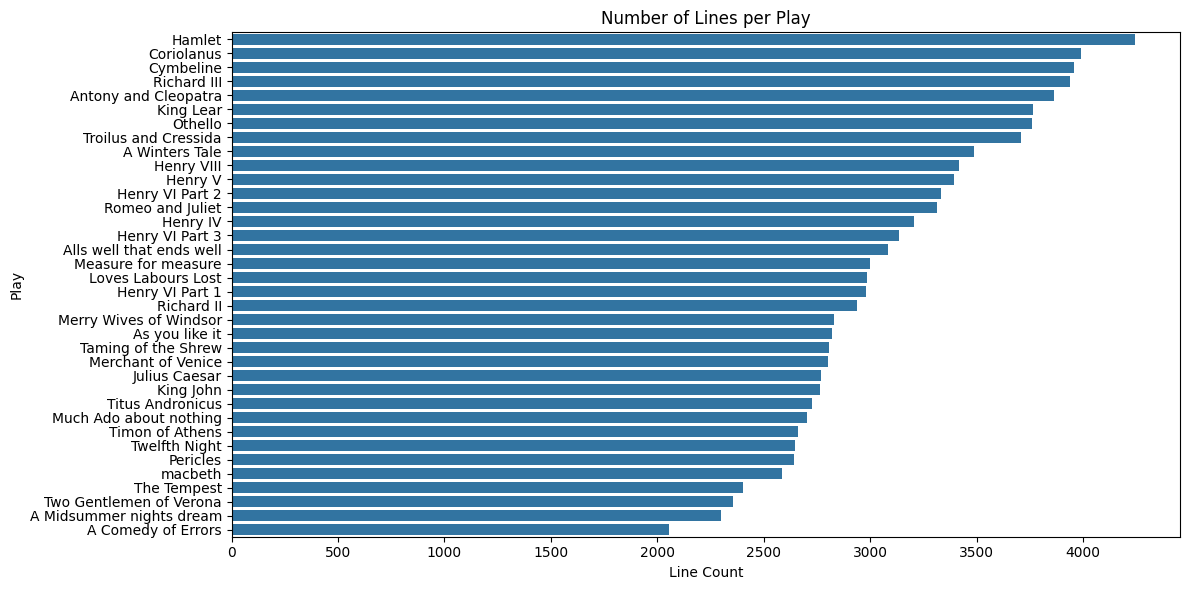

In [42]:
# Number of lines per play
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='Play', order=df['Play'].value_counts().index)
plt.title('Number of Lines per Play')
plt.xlabel('Line Count')
plt.ylabel('Play')
plt.tight_layout()
plt.show()

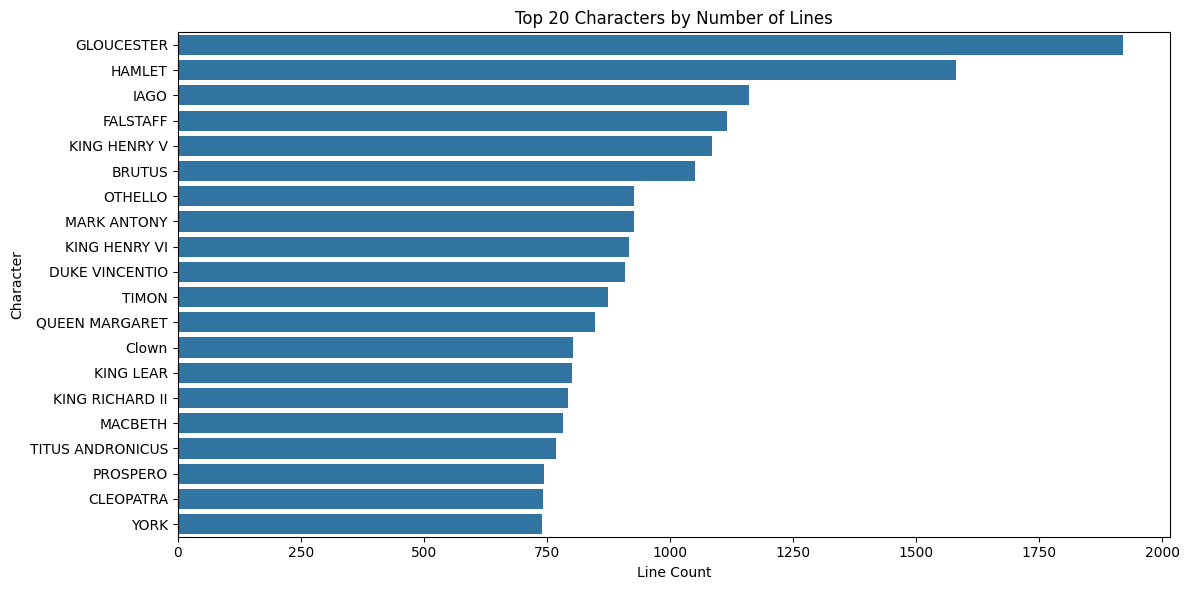

In [43]:
# Top 20 Characters by line count
top_characters = df['Player_filled'].value_counts().head(20)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_characters.values, y=top_characters.index)
plt.title('Top 20 Characters by Number of Lines')
plt.xlabel('Line Count')
plt.ylabel('Character')
plt.tight_layout()
plt.show()

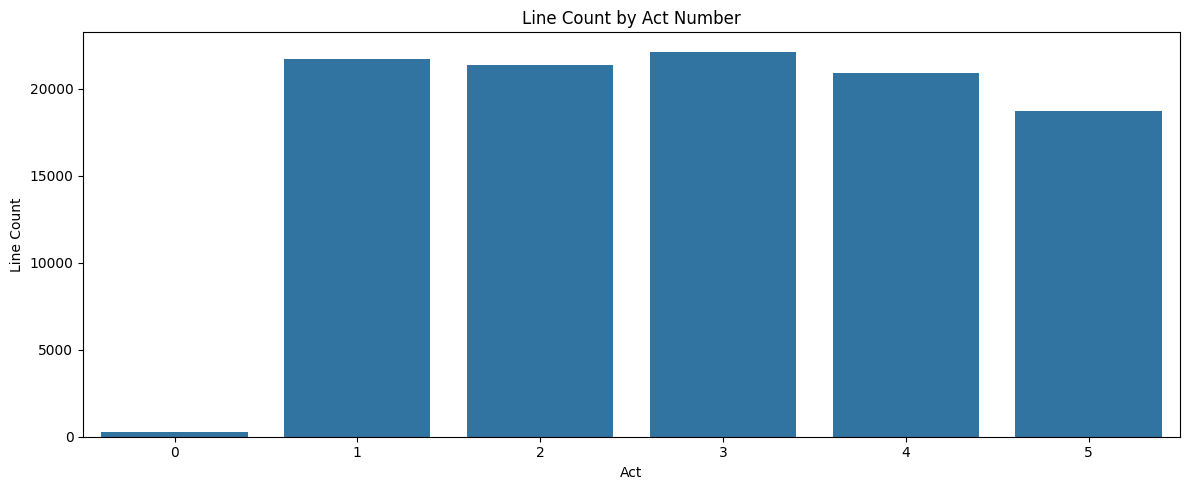

In [44]:
# Lines per ActSceneLine (non-null only)
scene_counts = df['ActSceneLine'].dropna().str.extract(r'^(\d+)\.(\d+)')[0].value_counts().sort_index()
plt.figure(figsize=(12, 5))
sns.barplot(x=scene_counts.index, y=scene_counts.values)
plt.title('Line Count by Act Number')
plt.xlabel('Act')
plt.ylabel('Line Count')
plt.tight_layout()
plt.show()

count    111396.000000
mean         38.196093
std          13.407790
min           1.000000
25%          34.000000
50%          41.000000
75%          46.000000
max        1029.000000
Name: LineLength, dtype: float64


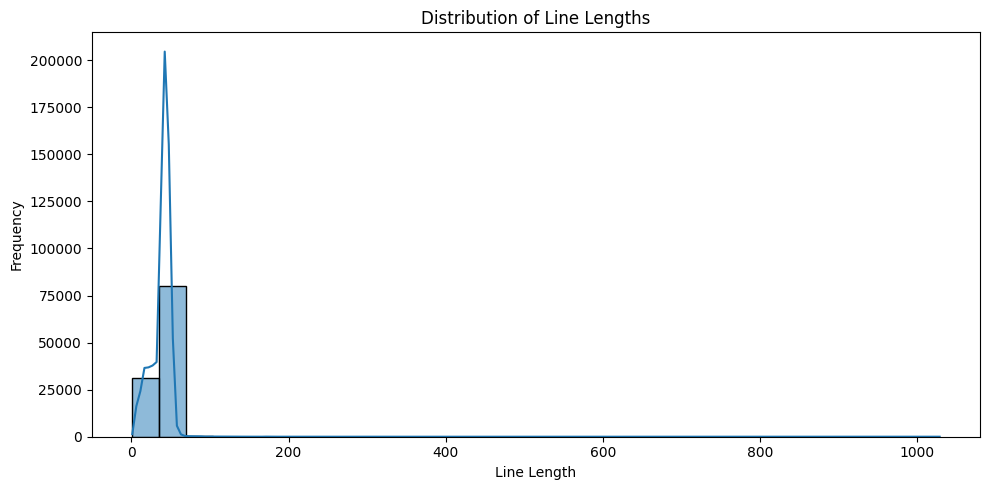

Percentage of data maintained by dropping lines with more than 60 characters: 99.49 %


In [45]:
# Distribution of Line Lengths
print(df['LineLength'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(df['LineLength'], bins=30, kde=True)
plt.title('Distribution of Line Lengths')
plt.xlabel('Line Length')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

print(f"Percentage of data maintained by dropping lines with more than 60 characters: {sum(df['LineLength'] <= 60)/df.shape[0] * 100:.2f} %")

### Cleaning

We can see that most lines are relatively short with a mean of 38 characters. There is a long right tail where the longest line is 1029 characters. We can also see that 75% of entries are 46 characters.

It makes sense to drop the few long lines and simplify the model. We will retaining over 99% of the data, which is statistically robust. The very long lines are extreme outliers (up to 1,029 characters) and likely:
-   Rare monologues.
-   Stage directions or meta-text
-   Structurally different from most training samples.
-   keeping them will likly cause uneven input lengths which in turn can cause inefficient batching.
-   Increases memory use and training time.
-   Adds noise for models.

In [46]:
# Going forward we will use the short version
df_short = df[df['LineLength'] <= 60].copy()

# Drop non-speech rows.
# As an example:
print(f"Lines without a player:\n {df_short['PlayerLine'][df_short['Player'].isna()][:4]}")
print(f"\nLines where all character are uppercase:\n {df_short['PlayerLine'][df_short['PlayerLine'].str.isupper()][:4]}")

df_short = df_short[df_short['Player'].notnull()]
df_short = df_short[~df_short['PlayerLine'].str.isupper()]

Lines without a player:
 0                                    ACT I
1             SCENE I. London. The palace.
2015    Eastcheap. The Boar's-Head Tavern.
2016           Enter FALSTAFF and BARDOLPH
Name: PlayerLine, dtype: object

Lines where all character are uppercase:
 0         ACT I
645      ACT II
1547    ACT III
2227     ACT IV
Name: PlayerLine, dtype: object


In [47]:
# Look for brackets or common stage direction words
candidates = df_short[df_short['PlayerLine'].str.contains(r'\[|\(|enter|exit|aside', case=False, regex=True)]
print(candidates['PlayerLine'].head(10))
df_short = df_short.drop(candidates.index)

# Drop duplicated Player Lines
df_short = df_short.drop_duplicates(subset='PlayerLine')

# Lowercasing for simpler models.
df_short['PlayerLineLower'] = df_short['PlayerLine'].str.lower()



113        Enter the PRINCE OF WALES and FALSTAFF
214                                   Enter POINS
264                                 Exit Falstaff
299                                    Exit Poins
323                                          Exit
347                                Exit Worcester
461                            Re-enter WORCESTER
647    Enter a Carrier with a lantern in his hand
651                        [Within]   Anon, anon.
655                         Enter another Carrier
Name: PlayerLine, dtype: object


### Modelling
We will implement two models. The first is a character-level LSTM model, selected for its ease of implementation and suitability for learning character sequences in short poetic lines. This model processes each line as a sequence of characters, learning to predict the next character in context. It requires building a custom character vocabulary, converting text to indexed sequences, and training the LSTM with a softmax output over the character set. The second model is a pretrained GPT-2 transformer, chosen for its ability to capture long-range dependencies and generate coherent using subword tokenization. GPT-2 leverages HuggingFace's tokenizer and model API, allowing us to fine-tune it directly on our dataset. For both models, we prepare the data appropriately (character vs. subword tokens), train using teacher forcing, and evaluate generation quality by using Sample Generation. This setup provides a comparison between a traditional RNN-based generator and a modern transformer-based model.

#### LSTM Model

In [48]:
# Character level tokenization
# 1- Build the character vocabulary
lines = df_short['PlayerLineLower'].tolist()
all_text = "\n".join(lines)

# Unique characters sorted by frequency or alphabetically
char_counts = Counter(all_text)
chars = sorted(char_counts)
vocab_size = len(chars)

# 2. Create mappings
char2idx = {char: idx for idx, char in enumerate(chars)}
idx2char = {idx: char for char, idx in char2idx.items()}

# 3. Encode all lines as sequences of integer IDs
def encode_line(line, char2idx):
    return [char2idx[c] for c in line if c in char2idx]
encoded_lines = [encode_line(line, char2idx) for line in lines]

# 4. Create input-output training pairs
# For each line: input = "To b", target = "o be "
sequence_length = 60  # pad or truncate to fixed length
input_seqs = []
target_seqs = []

for seq in encoded_lines:
    if len(seq) < 2:
        continue
    # Pad if too short
    if len(seq) < sequence_length + 1:
        seq = seq + [char2idx[' ']] * (sequence_length + 1 - len(seq))
    else:
        seq = seq[:sequence_length + 1]
    input_seqs.append(seq[:-1])   # e.g., if input is "To b"
    target_seqs.append(seq[1:])   # e.g., we will try to predict "o be"


# Convert to PyTorch tensors
X = torch.tensor(input_seqs, dtype=torch.long)
Y = torch.tensor(target_seqs, dtype=torch.long)

print(f"Vocabulary size: {vocab_size}")
print(f"X shape: {X.shape}, Y shape: {Y.shape}")

Vocabulary size: 47
X shape: torch.Size([104335, 60]), Y shape: torch.Size([104335, 60])


In [49]:
# Subset data for tuning
subset_size = 10000
X_sub = X[:subset_size]
Y_sub = Y[:subset_size]


# Custom dataset class
class CharDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Split & load using dataLoader
dataset = CharDataset(X_sub, Y_sub)

# Split into train/val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

### LSTM model design

We designed our character-level LSTM model to be simple, flexible, and effective for learning patterns in Shakespearean text. The model has the following layers:
-   Embedding layer that turns character indices into dense vectors, helping the model understand relationships between characters. 
-   Multi-layer LSTM that captures how characters relate to each other over time in a sequence
I chose LSTM (RNN) over other types of networks because it works well with longer sequences and reduces problems like vanishing gradients.
-   Linear layer maps the output to the full character vocabulary so the model can predict the next character. 

This design is modular, which means we can easily change settings like embedding size, hidden dimension, number of layers, and dropout. This makes it easier to tune the model and test different versions. Overall, the model is simple enough to train quickly and might be strong enough to generate good results for our task.

In [50]:
# Modular LSTM model to streamline hyperparameter tuning
class CharLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout):
        super(CharLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim) # Maps each character index to a dense vector (embedding).
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, # Processes the embedded character sequence to capture temporal dependencies.
                            batch_first=True, dropout=dropout if num_layers > 1 else 0.0)
        self.fc = nn.Linear(hidden_dim, vocab_size) # Projects the output of each LSTM step into the character vocabulary space.


    def forward(self, x):
        x = self.embedding(x) # [batch, seq_len] to [batch, seq_len, embed_dim]
        output, _ = self.lstm(x) # [batch, seq_len, hidden_dim]
        logits = self.fc(output) # [batch, seq_len, vocab_size] Each logit corresponds to the score for predicting a specific character.
        return logits

In [ ]:
# Hyperparameter options
param_grid = {
    'embedding_dim': [64, 128],
    'hidden_dim': [128, 256],
    'num_layers': [2, 3],
    'dropout': [0.1, 0.2, 0.3]
}

# Keys and value lists
keys = list(param_grid.keys())
value_lists = list(param_grid.values())

# Create meshgrid and flatten
grids = np.meshgrid(*value_lists, indexing='ij')
flattened = np.stack([g.flatten() for g in grids], axis=-1)

# Create a dict with all combinations
param_combinations = []
for row in flattened:
    combo = {}
    for i, key in enumerate(keys):
        val = row[i]
        # Cast to int unless the key is 'dropout'
        if 'dropout' in key:
            combo[key] = float(val)
        else:
            combo[key] = int(val)
    param_combinations.append(combo)

# Training function
def train_model(model, train_loader, val_loader, vocab_size, num_epochs=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam (Adaptive Moment Estimation) Optimizer to update the weights with momentum
    criterion = nn.CrossEntropyLoss() # loss func
    best_val_loss = float('inf') # initiate loss at infinity to be used at if < statement, store improvements.

    for epoch in range(num_epochs):
        model.train()
        for X_batch, Y_batch in train_loader: # batch loop
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device) # move model to GPU/CPU
            optimizer.zero_grad() # reset gradiant for each itteration
            logits = model(X_batch) # Generate output
            loss = criterion(logits.view(-1, vocab_size), Y_batch.view(-1)) # cross entropy loss
            loss.backward() # calc gradients of the loss for all learnable model parameter
            optimizer.step() # Updates the model parameters using the gradients calculated by (Adam)

        model.eval() # switch model to eval mode
        val_loss = 0 # storage object
        with torch.no_grad(): # Disable gradiant calc for validation
            for X_val, Y_val in val_loader:
                X_val, Y_val = X_val.to(device), Y_val.to(device)
                val_logits = model(X_val)
                loss = criterion(val_logits.view(-1, vocab_size), Y_val.view(-1))
                val_loss += loss.item() # running sum for loss on all batches
        avg_val_loss = val_loss / len(val_loader) # average loss across batches for this epoch
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()

    return best_val_loss, best_model_state

# Loop through combinations
def run_grid_search(X, Y, batch_size=64):
    # Prepare data
    dataset = CharDataset(X, Y)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Create storage objects
    results = []
    best_loss = float('inf')
    best_config = None
    best_model_state = None

    # Loop through different hyperparameters combinations
    for params in param_combinations:
        # Enforce correct types again to avoid errors after hours of training
        typed_params = {}
        for key, value in params.items():
            if key == 'dropout':
                typed_params[key] = float(value)
            else:
                typed_params[key] = int(value)

        model = CharLSTMModel(vocab_size=int(len(char2idx)), **typed_params)
        val_loss, model_state = train_model(model, train_loader, val_loader, vocab_size=len(char2idx))
        results.append((params, val_loss))
        print(f"Params: {params}, Val Loss: {val_loss:.4f}")

        # Store max accuracy
        if val_loss < best_loss:
            best_loss = val_loss
            best_config = params
            best_model_state = model_state

    return best_config, best_model_state, results

In [ ]:
# If best config file is saved from a previous run, read it and skip tuning.
if os.path.exists(best_config_LSTM_path):
   with open(best_config_LSTM_path, 'r') as fp:
    best_config = json.load(fp)

else:
    # Run tuning loop on a subset
    best_config, final_model, all_results = run_grid_search(X[:10000], Y[:10000])
    with open(best_config_LSTM_path, 'w') as fp:
        json.dump(best_config,fp)

print("\nBest Hyperparameters:")
print(best_config)


Best Hyperparameters:
{'embedding_dim': 128, 'hidden_dim': 256, 'num_layers': 2, 'dropout': 0.1}


Epoch 1/10 — Train Loss: 1.1642, Val Loss: 0.9627
Epoch 2/10 — Train Loss: 0.9374, Val Loss: 0.9021
Epoch 3/10 — Train Loss: 0.8913, Val Loss: 0.8707
Epoch 4/10 — Train Loss: 0.8662, Val Loss: 0.8560
Epoch 5/10 — Train Loss: 0.8492, Val Loss: 0.8435
Epoch 6/10 — Train Loss: 0.8369, Val Loss: 0.8351
Epoch 7/10 — Train Loss: 0.8276, Val Loss: 0.8280
Epoch 8/10 — Train Loss: 0.8198, Val Loss: 0.8244
Epoch 9/10 — Train Loss: 0.8136, Val Loss: 0.8213
Epoch 10/10 — Train Loss: 0.8081, Val Loss: 0.8189


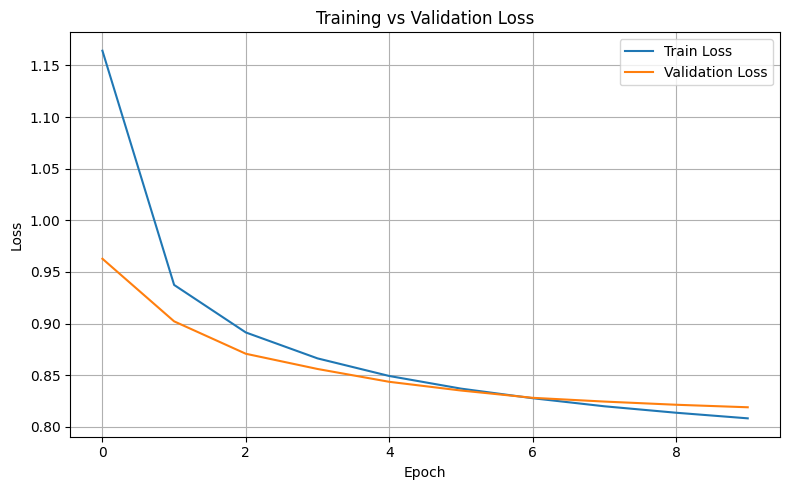

In [64]:
# Create new train/val split using full data
final_dataset = CharDataset(X, Y)
train_size = int(0.9 * len(final_dataset))
val_size = len(final_dataset) - train_size
train_dataset, val_dataset = random_split(final_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

# Training function
def train_model_with_history(model, train_loader, val_loader, vocab_size, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Create storage objects
    best_val_loss = float('inf')
    history = {"train_loss": [], "val_loss": []}

    # Train
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0 # store running sum loss from all batches
        for X_batch, Y_batch in train_loader: # batch loop
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device) # mve data to gpu/cpu
            optimizer.zero_grad() # resetting gradiants from last itteration
            logits = model(X_batch) # model output
            loss = criterion(logits.view(-1, vocab_size), Y_batch.view(-1)) # reshape logits and Y to enable crossEntropy loss calculation
            loss.backward() # Computes gradients of loss for all model parameters
            optimizer.step() # update model params using gradients and torch.optim.Adam optimizer
            running_train_loss += loss.item() # store batch loss

        avg_train_loss = running_train_loss / len(train_loader) # average loss for all batches in this epoch

        # Validation
        model.eval() # Set model to evaluation mode
        running_val_loss = 0
        with torch.no_grad(): # no need for back propagation during validation
            for X_val, Y_val in val_loader: # batch loop
                X_val, Y_val = X_val.to(device), Y_val.to(device) # move data to device
                val_logits = model(X_val) # model output
                loss = criterion(val_logits.view(-1, vocab_size), Y_val.view(-1)) # calc loss
                running_val_loss += loss.item() # running sum

        avg_val_loss = running_val_loss / len(val_loader) # average across batch

        # Store history
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        # Store max
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()

    return best_val_loss, best_model_state, history


# If model is already trained and saved, read it, else train and save
if os.path.exists(LSTMModelPath):
    # Load best model weights if not already loaded
    LSTMModel = CharLSTMModel(
        vocab_size=len(char2idx),
        embedding_dim=best_config['embedding_dim'],
        hidden_dim=best_config['hidden_dim'],
        num_layers=best_config['num_layers'],
        dropout=best_config['dropout']
    )

    LSTMModel.load_state_dict(torch.load(LSTMModelPath))
    LSTMModel.to("cuda" if torch.cuda.is_available() else "cpu")

    with open(LSTM_history_path, 'r') as fp:
        history = json.load(fp) 

else:
    # Run training and save
    # Train the final model with history tracking
    final_model = CharLSTMModel(
        vocab_size=len(char2idx),
        embedding_dim=best_config['embedding_dim'],
        hidden_dim=best_config['hidden_dim'],
        num_layers=best_config['num_layers'],
        dropout=best_config['dropout']
    )

    final_val_loss, final_state, history = train_model_with_history(
        final_model, train_loader, val_loader,
        vocab_size=len(char2idx), num_epochs=10
    )
    final_model.load_state_dict(final_state)
    torch.save(final_model.state_dict(), LSTMModelPath)
    
    with open(LSTM_history_path, 'w') as fp:
        json.dump(history,fp)

# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Validation starts to take over training loss at epoch 6 which indicates over fitting. This suggest that we do not need more epochs for now unless we change something in the model to reduce overfitting.

### GPT-2 Transformers Model (Transfer Learning)
In our second model, we use GPT-2, a pretrained transformer available through Hugging Face. While GPT-2 is already trained on a broad English content, we fine-tune it on our Shakespeare dataset to adapt its language model to the poetic structure of the plays. This allows us to compare the generative capabilities of a fine-tuned transformer with our LSTM baseline in generating shakespearian text.

Due to time and computational resource constraints, I was unable to incorporate a dedicated validation step during the fine-tuning of the GPT-2 model. Large language models like GPT-2 are computationally intensive to train, and even modest tuning on a limited cloud runtime can quickly exhaust available resources. As a result, I focused on completing a full training cycle on the available data to observe baseline model behavior and assess feasibility. In future iterations, incorporating a validation split and enabling early stopping will be key to better controlling overfitting and improving generalization.

[Model Documentation](https://huggingface.co/docs/transformers/en/model_doc/gpt2)

In [ ]:
# pull my tuned model from huggingface repo
model_id = "Bilal1jk/Shakespeare-Bot"

# Load tuned tokenizer and model from Hub
tokenizer = GPT2Tokenizer.from_pretrained(model_id) # converting raw text into token IDs that the GPT-2 model can understand.
model = GPT2LMHeadModel.from_pretrained(model_id) # gpt-2 model with head attachment for text generation. Other GPT-2 model us the same transformer but are optimized for other tasks like classification, feature extraction, or embedding.

# set this to true if you want to train again, otherwise use the my tuned stored model from hugging face
trainLocally = False

if trainLocally:
    # Load tokenizer + model
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    model = GPT2LMHeadModel.from_pretrained('gpt2') # load the pre-trained gpt2 model instead of my tuned version


In [66]:
# Save the data to a .txt file one line per sample. GPT-2 can take lines input from text and no need for tabular data
shakespeareTxtPath = 'shakespeare.txt'
with open(shakespeareTxtPath, "w", encoding="utf-8") as f:
    for line in df_short['PlayerLine']:
        if isinstance(line, str) and len(line.strip()) > 0:
            f.write(line.strip() + "\n")


In [69]:
# Tokenize + Create Dataset
def load_dataset(file_path, tokenizer, block_size=128):
    return TextDataset(
        tokenizer=tokenizer,
        file_path=file_path,
        block_size=block_size
    )

if trainLocally:
    train_dataset = load_dataset(shakespeareTxtPath, tokenizer)
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In this section, we fine-tune a pretrained GPT-2 model on Shakespearean text using Hugging Face's Trainer API, which simplifies training by handling batching, loss computation, optimization, and model saving. We configure the training process using TrainingArguments, where we specify parameters such as the number of epochs, batch size and saving frequency. During training, Hugging Face integrates with Weights & Biases (wandb), a popular tool for experiment tracking and remote training monitoring. Wandb allows us to visualize training metrics like loss and learning rate in real-time, compare different runs, and keep a history of model artifacts. While optional, this integration offers helpful insights during model development and debugging.

[Link](https://wandb.ai/bilal1jk-boulder-colorado/huggingface/reports/train-loss-25-06-18-16-43-03---VmlldzoxMzI3MTA0Nw?accessToken=gfzu353ml0z9q0jmc24nxa05a3ewfuczy7vuiqc3f8isbxhewt5468evvaq65jw2) to wandb learning loss tracker showing covergence on training data.

In [70]:
# Training

# if model already trained, skip
if trainLocally:
    training_args = TrainingArguments(
        output_dir = '.\gp2model',
        overwrite_output_dir=True,
        num_train_epochs=3,
        per_device_train_batch_size=4, # per GPU batch
        save_steps=500, # checkpoints in case Kaggle disconnects book
        save_total_limit=2, # keep the 2 most recent checkpoints
        prediction_loss_only=True, # disables logging evaluation metrics like validation loss since we didnt split the data.
        logging_steps=100) # send loss to wandb every 100 steps

    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset
    )

    # Start training
    trainer.train()

    model.save_pretrained(gpt2ModelFolder)
    tokenizer.save_pretrained(gpt2ModelFolder)


<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\g'
C:\Users\Bilal\AppData\Local\Temp\ipykernel_9676\4069130271.py:6: SyntaxWarning: invalid escape sequence '\g'
  output_dir = '.\gp2model',


### Model Comparison
To compare the outputs of the LSTM and GPT2 models, we relied primarily on manual evaluation of generated samples rather than quantitative metrics. This decision was influenced by both time constraints and technical limitations, as training a reliable discriminator model for automated evaluation would have required additional GPU resources that were no longer available. Also, qualitative assessment remains a common and informative approach in text generation tasks, especially when the goal is to evaluate stylistic coherence and relevance to human language. While subjective, manual inspection allowed us to assess the models' ability to generate fluent, contextually appropriate text reflective of Shakespearean style. 

Please feel free to test different prompts on your local, kaggle or colab as I have attached the trained models and you do not need to train the model again.

In [71]:
def generate_text_LSTM(model, start_text, char2idx, idx2char, temperature=1.0, device='cpu'):
    """Generate text using a trained character-level LSTM model.

    Args:
        model (nn.Module):   A trained instance of CharLSTMModel.
        start_text (str): The initial seed string to begin text generation.
        char2idx (dict): A mapping from character to integer index used during training.
        idx2char (dict):  A mapping from index to character used to decode predictions.
        temperature (float, optional): Sampling temperature to control randomness:
                                    -Lower values (<1.0) yield more conservative, predictable text.
                                    -Higher values (>1.0) produce more diverse and risky text. Defaults to 1.0.
        device (str, optional): The device to run generation on. Defaults to 'cpu'.

    Returns:
        str: The full generated text including the seed and newly generated characters.

    Notes:
        The function generates text character by character using the model's predicted
        distribution over the vocabulary. The temperature parameter is used to scale
        the logits before sampling to adjust the randomness of the output.

    Example:
        >>> generate_text(model, start_text="To be", char2idx=char2idx, idx2char=idx2char)
            'To be or not to be...'
    """

    model.eval()

    input_chars = list(start_text.lower())
    input_ids = [char2idx.get(c, char2idx[' ']) for c in input_chars]  # fallback to space for unknowns

    input_tensor = torch.tensor(input_ids, dtype=torch.long).unsqueeze(0).to(device)  # shape: [1, seq_len]

    generated = input_chars.copy()

    # loop uses the predictions ot predict the next character.
    with torch.no_grad():
        for _ in range(200):
            # Only feed the last character if sequence is too long
            if input_tensor.size(1) > 100:
                input_tensor = input_tensor[:, -100:]

            output = model(input_tensor)

            last_logits = output[:, -1, :] / temperature  # dividing the output of the model by a very small number makes it more deterministic. It amplifies the final prob difference between all outcomes. The opposite blurs the lines a bit making the model more creative
            probs = F.softmax(last_logits, dim=-1) # soft max convert logits to probabilities vector
            next_id = torch.multinomial(probs, num_samples=1).item() # randomly pick one item from the prob vector. Items with higher prob are more likely to be picked (unfair dice)

            next_char = idx2char[next_id] # convert vector to character
            generated.append(next_char)

            # Prepare next input
            input_tensor = torch.cat([input_tensor, torch.tensor([[next_id]], device=device)], dim=1)

    return ''.join(generated)


In [79]:
def generate_gpt2_text(model,tokenizer, prompt, temperature=1.0, top_k=40, top_p=0.90, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """    Generate text using a fine-tuned GPT-2 model.


    Args:
        model (str): Path to the directory where the fine-tuned GPT-2 model and tokenizer are saved.
        prompt (str): Seed text to begin generation.
        temperature (float, optional): Controls randomness: higher = more random. Defaults to 1.0.
        top_k (int, optional): Limits sampling to top k most likely tokens. Defaults to 50.
        top_p (float, optional): Nucleus sampling: cumulative probability threshold. Defaults to 0.95.
        device (str, optional): CUDA if available, otherwise CPU. Defaults to 'cuda'if torch.cuda.is_available() else 'cpu'.

    Returns:
        str: The full generated text starting from the given prompt.
    """
    model.to(device)
    model.eval()

    # Encode prompt
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    # Generate text
    output_ids = model.generate(
        input_ids,
        max_length=20,
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )

    return tokenizer.decode(output_ids[0], skip_special_tokens=True)


In [81]:
# Example prompts
prompts = ["To be or ", "My heart ", 'Forever ', "The king ", 'Love me ']

# Load best LSTM model
LSTMModel = CharLSTMModel(
    vocab_size=len(char2idx),
    embedding_dim=best_config['embedding_dim'],
    hidden_dim=best_config['hidden_dim'],
    num_layers=best_config['num_layers'],
    dropout=best_config['dropout']
)
LSTMModel.load_state_dict(torch.load(LSTMModelPath))
LSTMModel.to("cuda" if torch.cuda.is_available() else "cpu")

# Initialize output dictionary
output = {}

for prompt in prompts:

    output[prompt] = {}  # Initialize dictionary for this prompt
    lstmPrompt = prompt.lower() # the LSTM model doesn't work well with uppercase  letter, it needs a space at the end to know it needs to start a new word and not complette the existing word.

    # Generate using LSTM
    response_lstm = generate_text_LSTM(
        model=LSTMModel,
        start_text=lstmPrompt,
        char2idx=char2idx,
        idx2char=idx2char,
        temperature=0.1
    )
    output[prompt]['LSTM'] = response_lstm
    
    gpt2Prompt = prompt.strip() # remove trailing space added to each prompt to accomudate LSTM
    # Generate using GPT-2
    response_gpt2 = generate_gpt2_text(
        model = model,
        tokenizer = tokenizer,
        prompt=gpt2Prompt,
        temperature=0.8
    )
    output[prompt]['GPT2'] = response_gpt2

output


{'To be or ': {'LSTM': 'to be or nothing but the state of men,                                                                                                                                                                           ',
  'GPT2': "To be or no, 'tis not a question of that:\nTo be or no, '"},
 'My heart ': {'LSTM': 'my heart is not so fair as they say,                                                                                                                                                                             ',
  'GPT2': "My heart is the same, I know't:\nThe queen hath brought forth my husband,\n"},
 'Forever ': {'LSTM': 'forever the prince of the state of the state,                                                                                                                                                                   ',
  'GPT2': 'Forever thou art,\nWhen my soul hath been thus free from my thoughts,\nWhen all'},
 'The king ': {'LSTM': 'the king hath 

### Conclusion
In this project, we developed and compared two generative models, an LSTM and a GPT-2 transformer model, to produce text in the style of Shakespeare. While both models were able to generate 'relativly' more coherent outputs, qualitative evaluation revealed that GPT-2 captured more fluent and contextually consistent phrasing, likely due to its larger pretraining data and architectural advantages. The LSTM model was carefully tuned and monitored with a validation set to detect and prevent overfitting, which helped guide training decisions. In contrast, GPT-2 was fine-tuned without validation monitoring due to resource limitations, which may have affected its generalization performance. Moving forward, incorporating validation tracking during GPT-2 training would improve reliability, and introducing a discriminator or classification-based evaluation could offer more objective, quantitative comparisons. Additionally, experimenting with more advanced models such as GPT-Neo or fine-tuning on domain-specific text could further enhance output quality and stylistic accuracy.